In [50]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn import model_selection
from sklearn import metrics
from skopt import dump, load
from scipy.stats import reciprocal
from skopt import gp_minimize
import skopt
import numpy as np
import pandas as pd
import keras_tuner as kt
from sklearn import metrics
import datetime
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data from Keras

In [17]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

In [18]:
print(f'Train Shape: {x_train_full.shape} {y_train_full.shape}')
print(f'Test Shape: {x_test.shape} {y_test.shape}')

Train Shape: (60000, 28, 28) (60000,)
Test Shape: (10000, 28, 28) (10000,)


# Preprocess Data

In [19]:
x_train_full = x_train_full / 255.0
x_test = x_test / 255.0
x_valid, x_train = x_train_full[:5000], x_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Building and Testing Simple Model

In [20]:
def build_simple_model():
    model = keras.models.Sequential()
    
    # Input Layer
    model.add(keras.layers.Flatten(input_shape=(28, 28), name='input_layer'))
    
    # Hidden Layers
    model.add(keras.layers.Dense(units=300, activation='relu', name='hidden_layer_0'))
    model.add(keras.layers.Dense(units=100, activation='relu', name='hidden_layer_1'))
    
    # Output Layer
    model.add(keras.layers.Dense(units=10, activation='softmax', name='output_layer'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy']
    )
    
    return model

In [21]:
sm_model = build_simple_model()

In [22]:
history = sm_model.fit(x_train_full, y_train_full, epochs=30)

Train on 60000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 100us/sample - loss: 0.6884 - accuracy: 0.7721
Epoch 2/30
60000/60000 [==============================] - 6s 98us/sample - loss: 0.4791 - accuracy: 0.8320
Epoch 3/30
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4363 - accuracy: 0.8474
Epoch 4/30
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4102 - accuracy: 0.8565
Epoch 5/30
60000/60000 [==============================] - 7s 109us/sample - loss: 0.3907 - accuracy: 0.8634
Epoch 6/30
60000/60000 [==============================] - 7s 111us/sample - loss: 0.3754 - accuracy: 0.8673
Epoch 7/30
60000/60000 [==============================] - 6s 102us/sample - loss: 0.3623 - accuracy: 0.8722
Epoch 8/30
60000/60000 [==============================] - 7s 108us/sample - loss: 0.3501 - accuracy: 0.8753
Epoch 9/30
60000/60000 [==============================] - 7s 116us/sample - loss: 0.3402 - accuracy: 0.8785
Epoch 

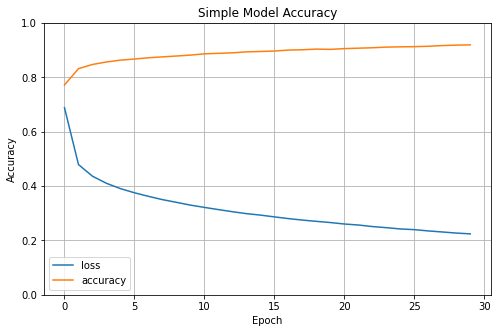

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Simple Model Accuracy')
plt.show()

In [35]:
accuracy_score(sm_model.predict_classes(x_test), y_test)

0.8848

In [11]:
# Save simple model
sm_model.save('models/simple_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/simple_model/assets


2022-02-28 22:40:14.118877: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Hyper Parameter Tuning with SciKit Optimize

In [36]:
def build_model(n_units_one, n_units_two, learning_rate, activation='relu', dropout_rate=.5):
    model = keras.models.Sequential()
    
    # Input Layer
    model.add(keras.layers.Flatten(input_shape=(28, 28), name='input_layer'))
    
    
    # Hidden Layers
    model.add(keras.layers.Dense(
        units=n_units_one,
        activation=activation,
        name=f'hidden_layer_{0}'
    ))
    
    model.add(keras.layers.Dense(
        units=n_units_two,
        activation=activation,
        name=f'hidden_layer_{1}'
    ))
    
    # Dropout layer

    model.add(keras.layers.Dropout(rate=dropout_rate))
    
    # Output Layer
    model.add(keras.layers.Dense(units=10, activation='softmax', name='output_layer'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        learning_rate=learning_rate,
        metrics=['accuracy']
    )
    
    return model

In [7]:
num_features = x_train_full.shape[1]
num_classes = 15
STATIC_PARAMS = { num_features, num_classes }
SPACE = [
    skopt.space.Integer(100, 700, name='n_units_one'),
    skopt.space.Integer(50, 500, name='n_units_two'),
    skopt.space.Real(0.0, .5, name='dropout_rate'),
    skopt.space.Real(1e-4, .1, prior='log-uniform', name='learning_rate')
]
CALLBACKS = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]

In [37]:
@skopt.utils.use_named_args(SPACE)
def objective(**params):
    print('-----------------------------------------------------------------------------------')
    print('Testing Parameters: ')
    print('Layer One: {} :: Layer Two {}'.format(params['n_units_one'], params['n_units_two']))
    print('Learning Rate: {} :: Dropout Rate: {}'.format(params['learning_rate'], params['dropout_rate']))
    
    valid_acc_scores = []
    cv = KFold(5)
    for train_idx, test_idx in cv.split(x_train_full):
        # Get train valid splits
        x_train, x_valid = x_train_full[train_idx], x_train_full[test_idx]
        y_train, y_valid = y_train_full[train_idx], y_train_full[test_idx]
        
        # fit model
        model = build_model(
            params['n_units_one'],
            params['n_units_two'],
            params['learning_rate'],
            dropout_rate=params['dropout_rate']
        )
        model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid), callbacks=CALLBACKS, verbose=0)
        trial_score = model.evaluate(x_valid, y_valid, verbose=0)[1]
        print(f'Validation Accuracy: {trial_score}')
        valid_acc_scores.append(trial_score)
    return -np.mean(valid_acc_scores)

In [13]:
results_gp = gp_minimize(objective, SPACE, n_calls=15, n_random_starts=4, random_state=1)

-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One: 698 :: Layer Two 470
Learning Rate: 0.09933940306516521 :: Dropout Rate: 0.06406222396467838
Validation Accuracy: 0.8933333158493042
Validation Accuracy: 0.890749990940094
Validation Accuracy: 0.8956666588783264
Validation Accuracy: 0.9003333449363708
Validation Accuracy: 0.8897500038146973
-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One: 242 :: Layer Two 228
Learning Rate: 0.010214993871440807 :: Dropout Rate: 0.19395537058100376
Validation Accuracy: 0.890666663646698
Validation Accuracy: 0.8842499852180481
Validation Accuracy: 0.89041668176651
Validation Accuracy: 0.8918333053588867
Validation Accuracy: 0.8834999799728394
-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One: 661 :: Layer Two 431
Learning Rate: 0.0037466616820236694 :: Dropout 

In [14]:
dump(results_gp, 'tuning/skopt_results')

# Model Evaluation

In [28]:
res_loaded = load('tuning/skopt_results')

### Best Parameters from Bayesian Cross Validation HP Tuning

In [31]:
print(f"""
    Best Avg. Val Acc: {-res_loaded.fun:.4f}
    Best Parameters:
    - Dense Layer 1: {res_loaded.x[0]}
    - Dense Layer 2: {res_loaded.x[1]}
    - Learning Rate: {res_loaded.x[2]}
    - Dropout Rate: {res_loaded.x[3]}
""")


    Best Avg. Val Acc: 0.8940
    Best Parameters:
    - Dense Layer 1: 698
    - Dense Layer 2: 470
    - Learning Rate: 0.06406222396467838
    - Dropout Rate: 0.09933940306516521



<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

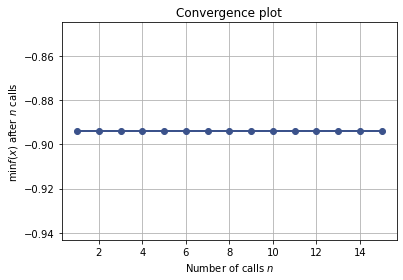

In [32]:
from skopt.plots import plot_convergence
plot_convergence(res_loaded)

In [43]:
n_units_one, n_units_two, learning_rate, dropout_rate = res_loaded.x[0], res_loaded.x[1], res_loaded.x[2], res_loaded.x[3]

tuned_model = build_model(n_units_one, n_units_two, learning_rate, dropout_rate=dropout_rate) 

In [44]:
history = tuned_model.fit(x_train_full, y_train_full, epochs=20, validation_split=.2, callbacks=CALLBACKS)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 17s 353us/sample - loss: 0.4885 - accuracy: 0.8232 - val_loss: 0.3963 - val_accuracy: 0.8490
Epoch 2/20
48000/48000 [==============================] - 16s 334us/sample - loss: 0.3693 - accuracy: 0.8652 - val_loss: 0.3656 - val_accuracy: 0.8643
Epoch 3/20
48000/48000 [==============================] - 19s 397us/sample - loss: 0.3285 - accuracy: 0.8777 - val_loss: 0.3668 - val_accuracy: 0.8665
Epoch 4/20
48000/48000 [==============================] - 17s 350us/sample - loss: 0.3075 - accuracy: 0.8847 - val_loss: 0.3253 - val_accuracy: 0.8820
Epoch 5/20
48000/48000 [==============================] - 20s 409us/sample - loss: 0.2866 - accuracy: 0.8925 - val_loss: 0.3169 - val_accuracy: 0.8872
Epoch 6/20
48000/48000 [==============================] - 17s 359us/sample - loss: 0.2739 - accuracy: 0.8978 - val_loss: 0.3346 - val_accuracy: 0.8860
Epoch 7/20
48000/48000 [====================

In [48]:
tuned_model.save('models/tuned_fashion_mnist')
accuracy_score(tuned_model.predict_classes(x_test), y_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-03-02 21:30:34.169889: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/tuned_fashion_mnist/assets


0.8911

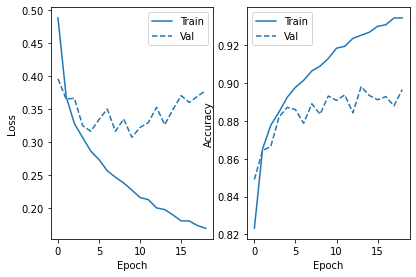

In [47]:
# This function is from the TensorFlow and SKOpt example given as an example
# Link to reference: https://canvas.wayne.edu/courses/161741/files/11567480/download?wrap=1
def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.tight_layout()
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)

Text(0.5, 69.0, 'Actual Labels')

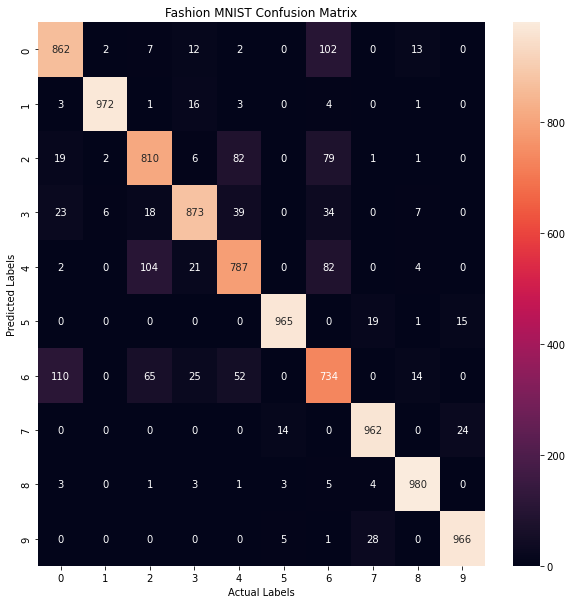

In [51]:
predicted = tuned_model.predict_classes(x_test)
cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Fashion MNIST Confusion Matrix')
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')

In [55]:
mapper = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat', 
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}
for i, val in enumerate(f1_score(y_test, predicted, average=None)):
    print(f'{mapper[i]} ({i}) : {val}')

T-shirt/top (0) : 0.8526211671612265
Trouser (1) : 0.9808274470232089
Pullover (2) : 0.8075772681954139
Dress (3) : 0.8926380368098159
Coat (4) : 0.8006103763987793
Sandal (5) : 0.9713135379969804
Shirt (6) : 0.7192552670259676
Sneaker (7) : 0.9553128103277061
Bag (8) : 0.9698169223156853
Ankle Boot (9) : 0.9635910224438902
